Data shape: (3588, 4)

Column names:
['DATE', 'BALANCE', 'EQUITY', 'DEPOSIT LOAD']

First few rows:
                 DATE  BALANCE   EQUITY  DEPOSIT LOAD
0 2020-01-01 00:00:00  10000.0  10000.0        0.0000
1 2020-01-02 00:40:00   9978.9   9958.7        0.0000
2 2020-01-02 01:45:00   9978.9   9978.9        0.0000
3 2020-01-02 08:24:00   9996.0   9970.2        0.0000
4 2020-01-02 11:44:00   9996.0   9996.1       66.6927
🚀 EXECUTING CORRECTED SIMULATION (NO LOOKAHEAD BIAS)

🔄 SIMULATION PARAMETERS (CORRECTED FOR LOOKAHEAD BIAS):
   Window: 90 days
   Stop: $-10
   Restart: $-10

📋 EVENTS:
🛑 Stop #1: 2020-01-02 | DD: $-21.10
⚠️  Restart detected #1: 2020-01-02 | DD: $-4.00 (resumes next period)
✅ Restart activated: 2020-01-02 | DD: $-4.00
🛑 Stop #2: 2020-01-07 | DD: $-15.00
⚠️  Restart detected #2: 2020-01-13 | DD: $-6.60 (resumes next period)
✅ Restart activated: 2020-01-13 | DD: $-6.60
🛑 Stop #3: 2020-01-14 | DD: $-39.40
⚠️  Restart detected #3: 2020-01-17 | DD: $-8.20 (resumes next pe

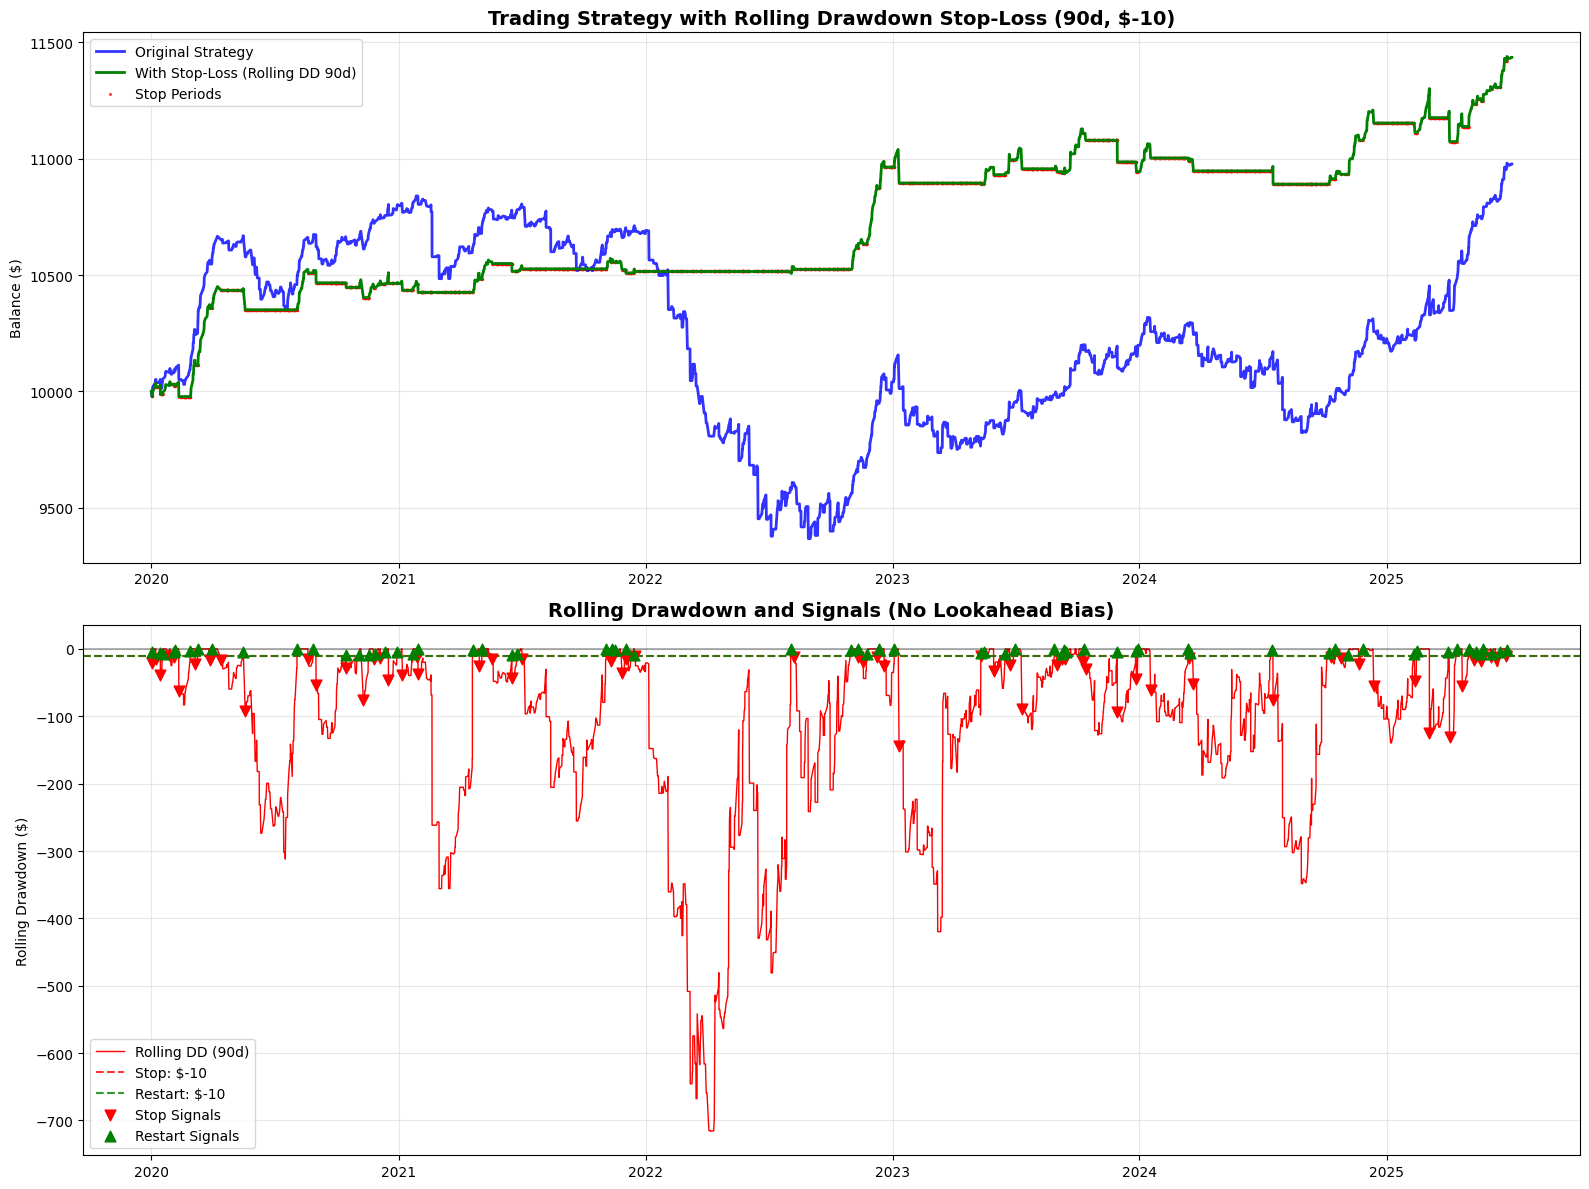


CONFIGURATION SUMMARY
✅ To modify parameters, change the variables above:
   ROLLING_WINDOW_DAYS = 90  # Days for rolling window
   STOP_THRESHOLD_USD = -10   # Stop threshold in dollars
   RESTART_MULTIPLIER = 1   # Restart multiplier

📈 Current result: 458.50$ improvement (4.18%)


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Read the CSV file with proper encoding and header
df = pd.read_csv('/workspaces/bollingerBands/notebooks/DATA/eurchf 120_2.csv', sep='\t', encoding='utf-16')

# Clean column names (remove angle brackets)
df.columns = [col.strip('<>') for col in df.columns]

# Convert DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y.%m.%d %H:%M')

# Display basic info about the data
print("Data shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Configuration parameters
ROLLING_WINDOW_DAYS = 90    # Days for rolling window
STOP_THRESHOLD_USD = -10    # Stop threshold in dollars (negative)
RESTART_MULTIPLIER = 1    # Multiplier for restart threshold (0.5 = half the stop threshold)

def simulate_stop_strategy(df, stop_threshold_usd=STOP_THRESHOLD_USD, 
                          restart_multiplier=RESTART_MULTIPLIER,
                          window_days=ROLLING_WINDOW_DAYS):
    """
    Simulates a stop-loss strategy based on rolling drawdown.
    
    CORRECTED FOR LOOKAHEAD BIAS:
    - When a restart signal is detected at time t, the strategy resumes from time t+1
    - This avoids using current period information for decisions in the same period
    """
    df_sim = df.copy()
    
    # Calculate rolling drawdown
    df_sim['rolling_max'] = df_sim['BALANCE'].rolling(window=window_days, min_periods=1).max()
    df_sim['rolling_drawdown_pct'] = (df_sim['BALANCE'] - df_sim['rolling_max']) / df_sim['rolling_max'] * 100
    df_sim['rolling_drawdown_abs'] = df_sim['BALANCE'] - df_sim['rolling_max']
    
    # Initialize columns for signals
    df_sim['stop_signals'] = 0
    df_sim['restart_signals'] = 0
    df_sim['active'] = True
    df_sim['adjusted_balance'] = df_sim['BALANCE'].copy()
    
    restart_threshold = stop_threshold_usd * restart_multiplier
    
    # State variables
    is_active = True
    balance_when_stopped = df_sim['BALANCE'].iloc[0]
    current_active_balance = df_sim['BALANCE'].iloc[0]
    stop_count = 0
    restart_count = 0
    restart_next_period = False  # Flag to indicate when to reactivate strategy
    
    print(f"\n🔄 SIMULATION PARAMETERS (CORRECTED FOR LOOKAHEAD BIAS):")
    print(f"   Window: {window_days} days")
    print(f"   Stop: ${stop_threshold_usd}")
    print(f"   Restart: ${restart_threshold}")
    print("\n📋 EVENTS:")
    
    for i in range(len(df_sim)):
        current_dd = df_sim['rolling_drawdown_abs'].iloc[i]
        
        # Handle restart from previous period
        if restart_next_period:
            is_active = True
            current_active_balance = balance_when_stopped
            restart_next_period = False
            print(f"✅ Restart activated: {df_sim['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f}")
        
        if is_active:
            # Strategy active - update progressively
            if i > 0:
                balance_change = df_sim['BALANCE'].iloc[i] - df_sim['BALANCE'].iloc[i-1]
                current_active_balance += balance_change
            df_sim.loc[df_sim.index[i], 'adjusted_balance'] = current_active_balance
            
            # Check stop condition
            if current_dd < stop_threshold_usd:
                is_active = False
                balance_when_stopped = current_active_balance
                df_sim.loc[df_sim.index[i], 'stop_signals'] = 1
                stop_count += 1
                print(f"🛑 Stop #{stop_count}: {df_sim['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f}")
        else:
            # Strategy stopped - maintain stop balance
            df_sim.loc[df_sim.index[i], 'adjusted_balance'] = balance_when_stopped
            
            # Check restart condition - but resume from next period
            if current_dd > restart_threshold:
                df_sim.loc[df_sim.index[i], 'restart_signals'] = 1
                restart_count += 1
                restart_next_period = True  # Will restart from next period
                print(f"⚠️  Restart detected #{restart_count}: {df_sim['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f} (resumes next period)")
        
        df_sim.loc[df_sim.index[i], 'active'] = is_active
    
    return df_sim, stop_count, restart_count

# Execute simulation
print("🚀 EXECUTING CORRECTED SIMULATION (NO LOOKAHEAD BIAS)")
df_result, num_stops, num_restarts = simulate_stop_strategy(df)

# Calculate performance metrics
original_balance = df['BALANCE'].iloc[-1]
final_balance = df_result['adjusted_balance'].iloc[-1]
improvement = final_balance - original_balance

print(f"\n" + "="*80)
print("SIMULATION RESULTS")
print("="*80)

print(f"💰 PERFORMANCE:")
print(f"   Original Balance: ${original_balance:.2f}")
print(f"   Final Balance:    ${final_balance:.2f}")
print(f"   Improvement:      ${improvement:.2f} ({improvement/original_balance*100:.2f}%)")

print(f"\n📊 OPERATION STATISTICS:")
print(f"   Number of Stops:    {num_stops}")
print(f"   Number of Restarts: {num_restarts}")

# Calculate time in stop
periods_stopped = len(df_result[df_result['active'] == False])
time_stopped_pct = periods_stopped / len(df_result) * 100
print(f"   Time in Stop:       {time_stopped_pct:.1f}% ({periods_stopped} periods)")

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Balance comparison
ax1.plot(df_result['DATE'], df_result['BALANCE'], 
         label='Original Strategy', linewidth=2, alpha=0.8, color='blue')
ax1.plot(df_result['DATE'], df_result['adjusted_balance'], 
         label=f'With Stop-Loss (Rolling DD {ROLLING_WINDOW_DAYS}d)', linewidth=2, color='green')

# Highlight stop periods
stop_periods = df_result[df_result['active'] == False]
if len(stop_periods) > 0:
    ax1.scatter(stop_periods['DATE'], stop_periods['adjusted_balance'], 
               color='red', s=2, alpha=0.6, label='Stop Periods')

ax1.set_title(f'Trading Strategy with Rolling Drawdown Stop-Loss ({ROLLING_WINDOW_DAYS}d, ${STOP_THRESHOLD_USD})', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Balance ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling drawdown with thresholds
ax2.plot(df_result['DATE'], df_result['rolling_drawdown_abs'], 
         linewidth=1, color='red', label=f'Rolling DD ({ROLLING_WINDOW_DAYS}d)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(y=STOP_THRESHOLD_USD, color='red', linestyle='--', alpha=0.8, 
           label=f'Stop: ${STOP_THRESHOLD_USD}')
ax2.axhline(y=STOP_THRESHOLD_USD * RESTART_MULTIPLIER, color='green', 
           linestyle='--', alpha=0.8, label=f'Restart: ${STOP_THRESHOLD_USD * RESTART_MULTIPLIER}')

# Stop/restart signals
stop_signals = df_result[df_result['stop_signals'] == 1]
restart_signals = df_result[df_result['restart_signals'] == 1]

if len(stop_signals) > 0:
    ax2.scatter(stop_signals['DATE'], stop_signals['rolling_drawdown_abs'], 
               color='red', s=60, marker='v', label='Stop Signals', zorder=5)
if len(restart_signals) > 0:
    ax2.scatter(restart_signals['DATE'], restart_signals['rolling_drawdown_abs'], 
               color='green', s=60, marker='^', label='Restart Signals', zorder=5)

ax2.set_title(f'Rolling Drawdown and Signals (No Lookahead Bias)', 
             fontsize=14, fontweight='bold')
ax2.set_ylabel('Rolling Drawdown ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"✅ To modify parameters, change the variables above:")
print(f"   ROLLING_WINDOW_DAYS = {ROLLING_WINDOW_DAYS}  # Days for rolling window")
print(f"   STOP_THRESHOLD_USD = {STOP_THRESHOLD_USD}   # Stop threshold in dollars")
print(f"   RESTART_MULTIPLIER = {RESTART_MULTIPLIER}   # Restart multiplier")
print(f"\n📈 Current result: {improvement:.2f}$ improvement ({improvement/original_balance*100:.2f}%)")
print("="*80)

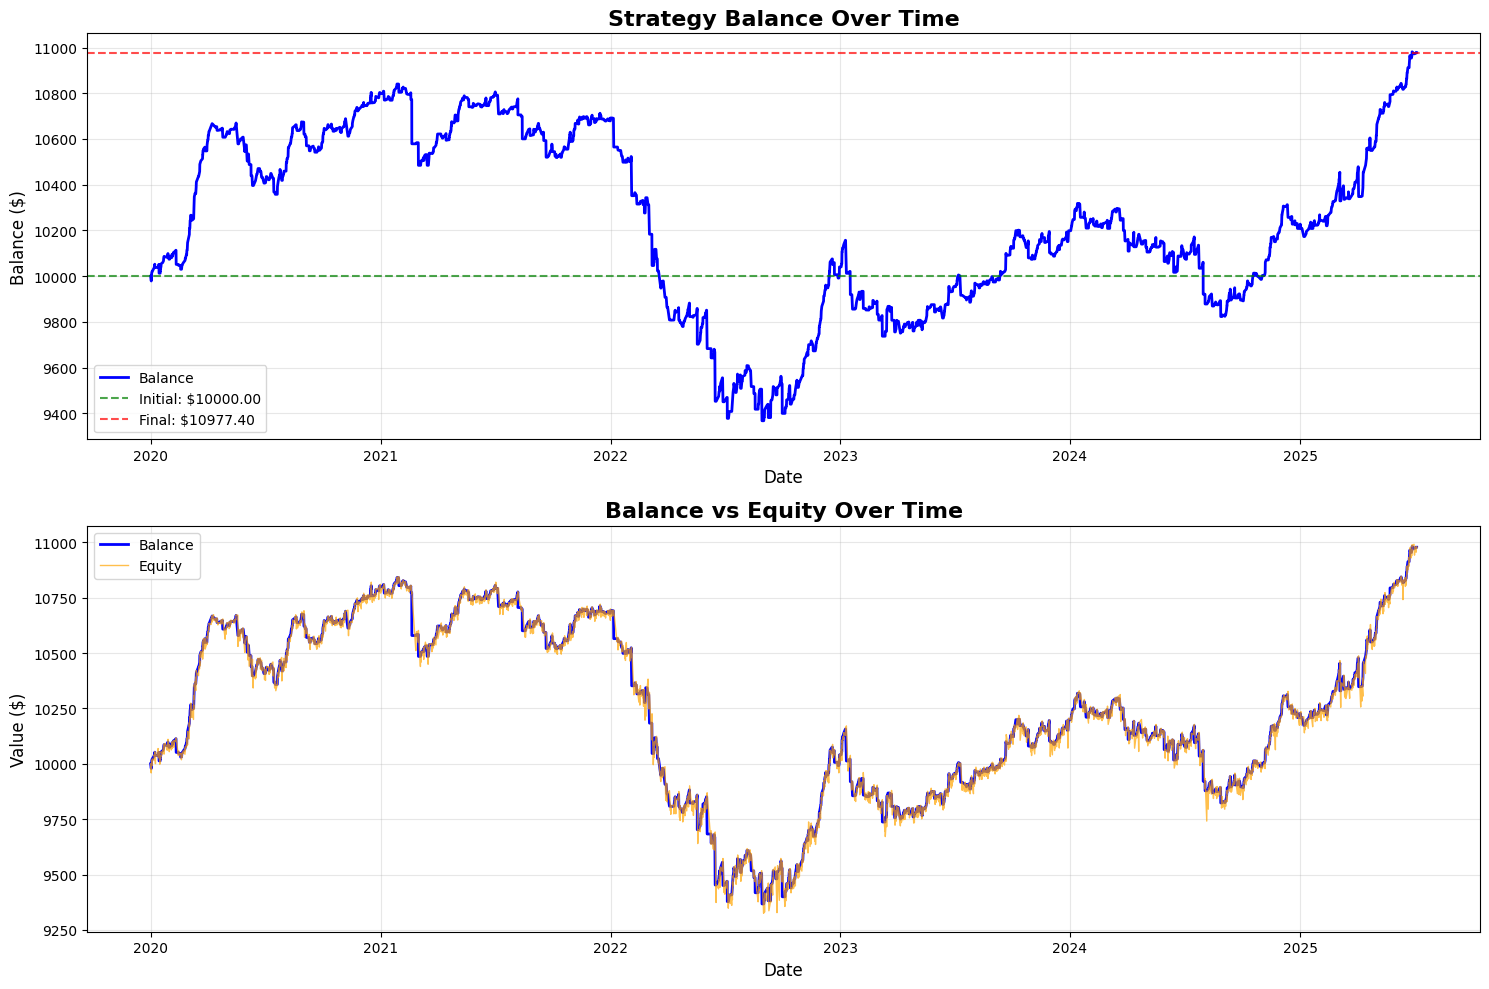


PERFORMANCE METRICS ANALYSIS
📊 DATA FREQUENCY ANALYSIS:
   Total days: 2011
   Total periods: 3588
   Periods per year: 651.67
   Average frequency: 0.56 days per period

PERFORMANCE COMPARISON
📈 ORIGINAL STRATEGY:
   Annualized Return: 1.79%
   Annualized Volatility: 4.08%
   Sharpe Ratio: 0.4392
   Max Drawdown: 13.59%
   Calmar Ratio: 0.1257

🛑 STOP-LOSS STRATEGY:
   Annualized Return: 2.48%
   Annualized Volatility: 1.79%
   Sharpe Ratio: 1.3844
   Max Drawdown: 2.13%
   Calmar Ratio: 1.1564

💡 IMPROVEMENTS:
   Sharpe Ratio Change: +0.9451
   Volatility Reduction: +56.06%
   Drawdown Reduction: +84.30%
   Calmar Ratio Change: +1.0307


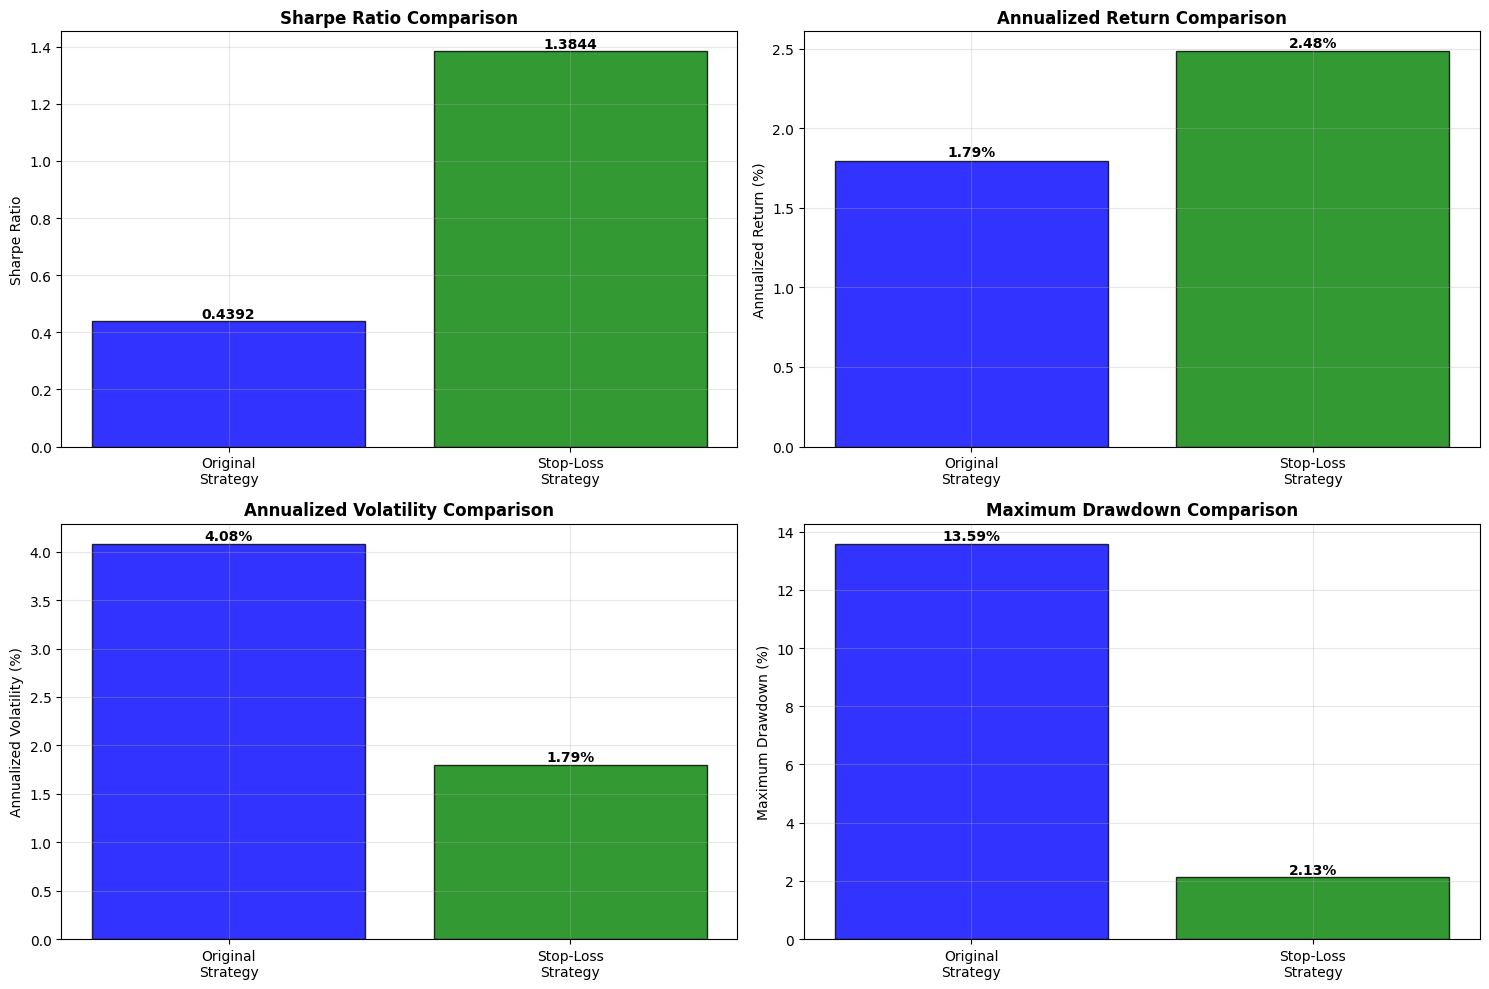


SUMMARY
✅ METHODOLOGY:
   - No lookahead bias: restart occurs from next period
   - Correct annualization based on actual data frequency
   - Realistic and implementable simulation

📊 KEY RESULTS:
   - Final Balance: $11435.90
   - Strategy Sharpe Ratio: 1.3844
   - Strategy vs Original: +0.9451 Sharpe improvement
   - Time in Stop: 71.9% of total time


In [47]:
# Convert DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y.%m.%d %H:%M')

# Create a comprehensive plot of the strategy balance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Balance over time
ax1.plot(df['DATE'], df['BALANCE'], linewidth=2, color='blue', label='Balance')
ax1.set_title('Strategy Balance Over Time', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Balance ($)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add some statistics
initial_balance = df['BALANCE'].iloc[0]
final_balance = df['BALANCE'].iloc[-1]
max_balance = df['BALANCE'].max()
min_balance = df['BALANCE'].min()

ax1.axhline(y=initial_balance, color='green', linestyle='--', alpha=0.7, label=f'Initial: ${initial_balance:.2f}')
ax1.axhline(y=final_balance, color='red', linestyle='--', alpha=0.7, label=f'Final: ${final_balance:.2f}')
ax1.legend()

# Plot 2: Balance and Equity comparison
ax2.plot(df['DATE'], df['BALANCE'], linewidth=2, color='blue', label='Balance')
ax2.plot(df['DATE'], df['EQUITY'], linewidth=1, color='orange', alpha=0.7, label='Equity')
ax2.set_title('Balance vs Equity Over Time', fontsize=16, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Value ($)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# PERFORMANCE METRICS CALCULATION
print("\n" + "="*80)
print("PERFORMANCE METRICS ANALYSIS")
print("="*80)

# Calculate returns for both strategies
original_returns = df_result['BALANCE'].pct_change().dropna()
strategy_returns = df_result['adjusted_balance'].pct_change().dropna()

# Calculate data frequency for correct annualization
total_days = (df_result['DATE'].iloc[-1] - df_result['DATE'].iloc[0]).days
total_periods = len(df_result)
periods_per_year = total_periods / (total_days / 365.25)

print(f"📊 DATA FREQUENCY ANALYSIS:")
print(f"   Total days: {total_days}")
print(f"   Total periods: {total_periods}")
print(f"   Periods per year: {periods_per_year:.2f}")
print(f"   Average frequency: {total_days/total_periods:.2f} days per period")

def calculate_metrics(returns, periods_per_year):
    """Calculate performance metrics with correct annualization"""
    annualized_return = (1 + returns.mean()) ** periods_per_year - 1
    annualized_volatility = returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
    
    return {
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio
    }

def calculate_additional_metrics(balance_series):
    """Calculate additional risk/return metrics"""
    returns = balance_series.pct_change().dropna()
    
    # Total return
    total_return = (balance_series.iloc[-1] / balance_series.iloc[0]) - 1
    
    # Win rate
    positive_returns = returns[returns > 0]
    win_rate = len(positive_returns) / len(returns) if len(returns) > 0 else 0
    
    # Maximum drawdown
    running_max = balance_series.expanding().max()
    drawdown = (balance_series - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    
    # Calmar ratio
    annualized_return = (balance_series.iloc[-1] / balance_series.iloc[0]) ** (periods_per_year / len(balance_series)) - 1
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else float('inf')
    
    return {
        'total_return': total_return,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    }

# Calculate metrics
original_metrics = calculate_metrics(original_returns, periods_per_year)
strategy_metrics = calculate_metrics(strategy_returns, periods_per_year)

original_additional = calculate_additional_metrics(df_result['BALANCE'])
strategy_additional = calculate_additional_metrics(df_result['adjusted_balance'])

print(f"\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

print(f"📈 ORIGINAL STRATEGY:")
print(f"   Annualized Return: {original_metrics['annualized_return']*100:.2f}%")
print(f"   Annualized Volatility: {original_metrics['annualized_volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {original_metrics['sharpe_ratio']:.4f}")
print(f"   Max Drawdown: {original_additional['max_drawdown']*100:.2f}%")
print(f"   Calmar Ratio: {original_additional['calmar_ratio']:.4f}")

print(f"\n🛑 STOP-LOSS STRATEGY:")
print(f"   Annualized Return: {strategy_metrics['annualized_return']*100:.2f}%")
print(f"   Annualized Volatility: {strategy_metrics['annualized_volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {strategy_metrics['sharpe_ratio']:.4f}")
print(f"   Max Drawdown: {strategy_additional['max_drawdown']*100:.2f}%")
print(f"   Calmar Ratio: {strategy_additional['calmar_ratio']:.4f}")

# Calculate improvements
sharpe_improvement = strategy_metrics['sharpe_ratio'] - original_metrics['sharpe_ratio']
volatility_reduction = (original_metrics['annualized_volatility'] - strategy_metrics['annualized_volatility']) / original_metrics['annualized_volatility']
drawdown_reduction = (original_additional['max_drawdown'] - strategy_additional['max_drawdown']) / original_additional['max_drawdown']

print(f"\n💡 IMPROVEMENTS:")
print(f"   Sharpe Ratio Change: {sharpe_improvement:+.4f}")
print(f"   Volatility Reduction: {volatility_reduction*100:+.2f}%")
print(f"   Drawdown Reduction: {drawdown_reduction*100:+.2f}%")
print(f"   Calmar Ratio Change: {strategy_additional['calmar_ratio'] - original_additional['calmar_ratio']:+.4f}")

# Visualization of metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sharpe Ratio comparison
categories = ['Original\nStrategy', 'Stop-Loss\nStrategy']
sharpe_values = [original_metrics['sharpe_ratio'], strategy_metrics['sharpe_ratio']]
colors = ['blue', 'green']

bars1 = ax1.bar(categories, sharpe_values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Sharpe Ratio')
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars1, sharpe_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Returns comparison
return_values = [original_metrics['annualized_return']*100, strategy_metrics['annualized_return']*100]
bars2 = ax2.bar(categories, return_values, color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('Annualized Return Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Annualized Return (%)')
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars2, return_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 3: Volatility comparison
volatility_values = [original_metrics['annualized_volatility']*100, strategy_metrics['annualized_volatility']*100]
bars3 = ax3.bar(categories, volatility_values, color=colors, alpha=0.8, edgecolor='black')
ax3.set_title('Annualized Volatility Comparison', fontsize=12, fontweight='bold')
ax3.set_ylabel('Annualized Volatility (%)')
ax3.grid(True, alpha=0.3)

for bar, value in zip(bars3, volatility_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 4: Maximum Drawdown comparison
drawdown_values = [original_additional['max_drawdown']*100, strategy_additional['max_drawdown']*100]
bars4 = ax4.bar(categories, drawdown_values, color=colors, alpha=0.8, edgecolor='black')
ax4.set_title('Maximum Drawdown Comparison', fontsize=12, fontweight='bold')
ax4.set_ylabel('Maximum Drawdown (%)')
ax4.grid(True, alpha=0.3)

for bar, value in zip(bars4, drawdown_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"✅ METHODOLOGY:")
print(f"   - No lookahead bias: restart occurs from next period")
print(f"   - Correct annualization based on actual data frequency")
print(f"   - Realistic and implementable simulation")
print(f"\n📊 KEY RESULTS:")
print(f"   - Final Balance: ${df_result['adjusted_balance'].iloc[-1]:.2f}")
print(f"   - Strategy Sharpe Ratio: {strategy_metrics['sharpe_ratio']:.4f}")
print(f"   - Strategy vs Original: {sharpe_improvement:+.4f} Sharpe improvement")
print(f"   - Time in Stop: {time_stopped_pct:.1f}% of total time")
print("="*80)

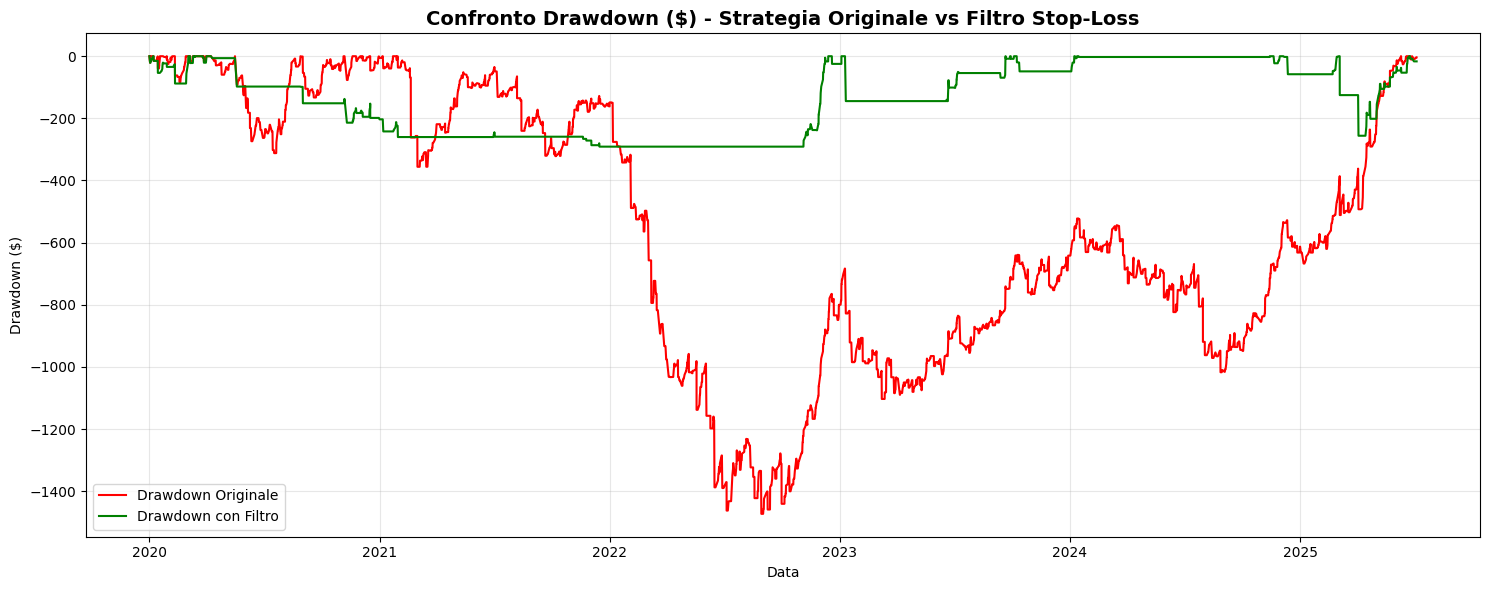

In [42]:
# Confronto dei drawdown in $ tra strategia originale e con filtro
def compute_drawdown(series):
    running_max = series.expanding().max()
    drawdown = series - running_max
    return drawdown

original_drawdown = compute_drawdown(df_result['BALANCE'])
filtered_drawdown = compute_drawdown(df_result['adjusted_balance'])

plt.figure(figsize=(15, 6))
plt.plot(df_result['DATE'], original_drawdown, label='Drawdown Originale', color='red', linewidth=1.5)
plt.plot(df_result['DATE'], filtered_drawdown, label='Drawdown con Filtro', color='green', linewidth=1.5)
plt.title('Confronto Drawdown ($) - Strategia Originale vs Filtro Stop-Loss', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Drawdown ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🔍 AVVIO GRID SEARCH - PARAMETRI OTTIMALI FILTRO ROLLING DRAWDOWN
📊 Testando 100 combinazioni di parametri...


Grid Search:   0%|          | 0/100 [00:00<?, ?it/s]

Grid Search: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]




✅ Completate 100 simulazioni valide

🏆 TOP 3 CONFIGURAZIONI PER OGNI METRICA:

📈 Miglior Miglioramento Finale:
   1. Window: 90.0d, Stop: $-10.0, Restart: 1.0
      → improvement: 0.0458
      → Return: 0.1436, DD: 0.0213, Sharpe: 12.8683
   2. Window: 90.0d, Stop: $-10.0, Restart: 0.7
      → improvement: 0.0439
      → Return: 0.1416, DD: 0.0214, Sharpe: 12.8017
   3. Window: 90.0d, Stop: $-10.0, Restart: 0.5
      → improvement: 0.0430
      → Return: 0.1407, DD: 0.0222, Sharpe: 12.7225

📈 Miglior Riduzione Drawdown:
   1. Window: 120.0d, Stop: $-10.0, Restart: 0.5
      → dd_improvement: 0.1154
      → Return: 0.1239, DD: 0.0205, Sharpe: 11.6157
   2. Window: 120.0d, Stop: $-10.0, Restart: 1.0
      → dd_improvement: 0.1153
      → Return: 0.1223, DD: 0.0205, Sharpe: 11.1295
   3. Window: 120.0d, Stop: $-10.0, Restart: 0.7
      → dd_improvement: 0.1152
      → Return: 0.1149, DD: 0.0207, Sharpe: 10.5055

📈 Miglior Miglioramento Sharpe:
   1. Window: 90.0d, Stop: $-10.0, Restart: 

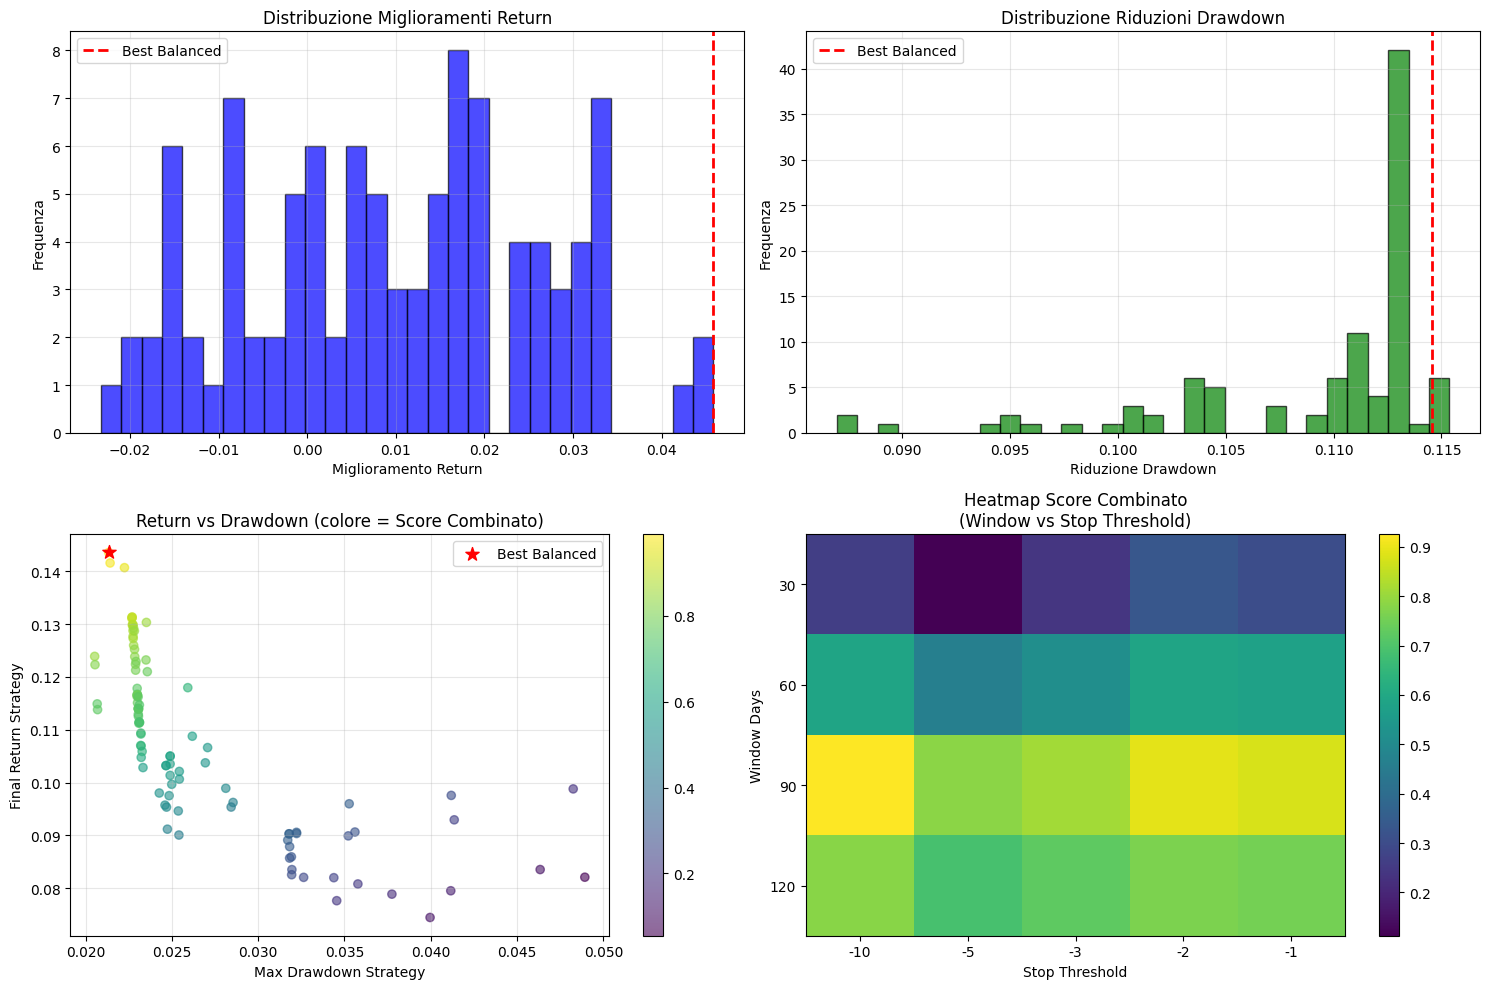


RACCOMANDAZIONI:
✅ Usa la configurazione bilanciata mostrata sopra come punto di partenza
✅ Considera le top 3 configurazioni per ogni metrica se hai priorità specifiche
✅ I parametri ottimali dipendono dal tuo obiettivo (max return, min drawdown, o bilanciato)


In [43]:
# 🔍 GRID SEARCH PER PARAMETRI OTTIMALI DEL FILTRO ROLLING DRAWDOWN

import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Definisci i parametri da testare
param_grid = {
    'rolling_window_days': [30, 60, 90, 120],
    'stop_threshold_usd': [-1, -2, -3, -5, -10],
    'restart_multiplier': [0.2, 0.3, 0.5, 0.7, 1.0]
}

# Funzione compatta per simulazione veloce
def fast_simulate(df, window_days, stop_threshold_usd, restart_multiplier):
    """Simulazione veloce senza output di debug"""
    df_sim = df.copy()
    
    # Calcola rolling drawdown
    df_sim['rolling_max'] = df_sim['BALANCE'].rolling(window=window_days, min_periods=1).max()
    df_sim['rolling_drawdown_abs'] = df_sim['BALANCE'] - df_sim['rolling_max']
    df_sim['adjusted_balance'] = df_sim['BALANCE'].copy()
    
    restart_threshold = stop_threshold_usd * restart_multiplier
    
    # Variabili di stato
    is_active = True
    balance_when_stopped = df_sim['BALANCE'].iloc[0]
    current_active_balance = df_sim['BALANCE'].iloc[0]
    restart_next_period = False
    
    for i in range(len(df_sim)):
        current_dd = df_sim['rolling_drawdown_abs'].iloc[i]
        
        if restart_next_period:
            is_active = True
            current_active_balance = balance_when_stopped
            restart_next_period = False
        
        if is_active:
            if i > 0:
                balance_change = df_sim['BALANCE'].iloc[i] - df_sim['BALANCE'].iloc[i-1]
                current_active_balance += balance_change
            df_sim.loc[df_sim.index[i], 'adjusted_balance'] = current_active_balance
            
            if current_dd < stop_threshold_usd:
                is_active = False
                balance_when_stopped = current_active_balance
        else:
            df_sim.loc[df_sim.index[i], 'adjusted_balance'] = balance_when_stopped
            if current_dd > restart_threshold:
                restart_next_period = True
    
    return df_sim

# Funzione per calcolare metriche di performance
def calculate_performance_metrics(df_result):
    """Calcola metriche di performance chiave"""
    original_balance = df_result['BALANCE']
    strategy_balance = df_result['adjusted_balance']
    
    # Calcola drawdown
    original_running_max = original_balance.expanding().max()
    strategy_running_max = strategy_balance.expanding().max()
    
    original_drawdown = (original_balance - original_running_max) / original_running_max
    strategy_drawdown = (strategy_balance - strategy_running_max) / strategy_running_max
    
    # Calcola returns
    original_returns = original_balance.pct_change().dropna()
    strategy_returns = strategy_balance.pct_change().dropna()
    
    # Metriche finali
    final_return_original = (original_balance.iloc[-1] / original_balance.iloc[0]) - 1
    final_return_strategy = (strategy_balance.iloc[-1] / strategy_balance.iloc[0]) - 1
    
    max_dd_original = abs(original_drawdown.min())
    max_dd_strategy = abs(strategy_drawdown.min())
    
    vol_original = original_returns.std() * np.sqrt(252)  # Annualizzata
    vol_strategy = strategy_returns.std() * np.sqrt(252)
    
    sharpe_original = (final_return_original / vol_original) if vol_original > 0 else 0
    sharpe_strategy = (final_return_strategy / vol_strategy) if vol_strategy > 0 else 0
    
    return {
        'final_return_strategy': final_return_strategy,
        'final_return_original': final_return_original,
        'improvement': final_return_strategy - final_return_original,
        'max_dd_strategy': max_dd_strategy,
        'max_dd_original': max_dd_original,
        'dd_improvement': max_dd_original - max_dd_strategy,
        'sharpe_strategy': sharpe_strategy,
        'sharpe_original': sharpe_original,
        'sharpe_improvement': sharpe_strategy - sharpe_original
    }

# Esegui grid search
print("🔍 AVVIO GRID SEARCH - PARAMETRI OTTIMALI FILTRO ROLLING DRAWDOWN")
print("="*80)

# Genera tutte le combinazioni
param_combinations = list(itertools.product(
    param_grid['rolling_window_days'],
    param_grid['stop_threshold_usd'], 
    param_grid['restart_multiplier']
))

print(f"📊 Testando {len(param_combinations)} combinazioni di parametri...")

results = []

# Esegui tutte le simulazioni
for window, stop_thresh, restart_mult in tqdm(param_combinations, desc="Grid Search"):
    try:
        df_result = fast_simulate(df, window, stop_thresh, restart_mult)
        metrics = calculate_performance_metrics(df_result)
        
        result = {
            'window_days': window,
            'stop_threshold': stop_thresh,
            'restart_multiplier': restart_mult,
            **metrics
        }
        results.append(result)
        
    except Exception as e:
        continue

# Converte in DataFrame per analisi
results_df = pd.DataFrame(results)

print(f"\n✅ Completate {len(results_df)} simulazioni valide")
print("="*80)

# Trova i migliori parametri per diverse metriche
metrics_to_optimize = [
    ('improvement', 'Miglior Miglioramento Finale'),
    ('dd_improvement', 'Miglior Riduzione Drawdown'),
    ('sharpe_improvement', 'Miglior Miglioramento Sharpe')
]

print("\n🏆 TOP 3 CONFIGURAZIONI PER OGNI METRICA:")
print("="*80)

for metric, description in metrics_to_optimize:
    print(f"\n📈 {description}:")
    top_configs = results_df.nlargest(3, metric)
    
    for i, (_, row) in enumerate(top_configs.iterrows(), 1):
        print(f"   {i}. Window: {row['window_days']}d, Stop: ${row['stop_threshold']}, Restart: {row['restart_multiplier']}")
        print(f"      → {metric}: {row[metric]:.4f}")
        print(f"      → Return: {row['final_return_strategy']:.4f}, DD: {row['max_dd_strategy']:.4f}, Sharpe: {row['sharpe_strategy']:.4f}")

# Configurazione "bilanciata" - score combinato
print(f"\n🎯 CONFIGURAZIONE BILANCIATA (Score Combinato):")
print("="*80)

# Normalizza le metriche e crea score combinato
results_df['norm_improvement'] = (results_df['improvement'] - results_df['improvement'].min()) / (results_df['improvement'].max() - results_df['improvement'].min())
results_df['norm_dd_improvement'] = (results_df['dd_improvement'] - results_df['dd_improvement'].min()) / (results_df['dd_improvement'].max() - results_df['dd_improvement'].min())
results_df['norm_sharpe_improvement'] = (results_df['sharpe_improvement'] - results_df['sharpe_improvement'].min()) / (results_df['sharpe_improvement'].max() - results_df['sharpe_improvement'].min())

# Score combinato (pesi uguali)
results_df['combined_score'] = (results_df['norm_improvement'] + results_df['norm_dd_improvement'] + results_df['norm_sharpe_improvement']) / 3

best_balanced = results_df.loc[results_df['combined_score'].idxmax()]

print(f"🥇 MIGLIORE CONFIGURAZIONE BILANCIATA:")
print(f"   Window: {best_balanced['window_days']} giorni")
print(f"   Stop Threshold: ${best_balanced['stop_threshold']}")
print(f"   Restart Multiplier: {best_balanced['restart_multiplier']}")
print(f"   Score Combinato: {best_balanced['combined_score']:.4f}")
print(f"\n📊 PERFORMANCE:")
print(f"   Return Strategy: {best_balanced['final_return_strategy']:.4f} ({best_balanced['final_return_strategy']*100:.2f}%)")
print(f"   Miglioramento: {best_balanced['improvement']:.4f} ({best_balanced['improvement']*100:.2f}%)")
print(f"   Max DD Strategy: {best_balanced['max_dd_strategy']:.4f} ({best_balanced['max_dd_strategy']*100:.2f}%)")
print(f"   Riduzione DD: {best_balanced['dd_improvement']:.4f} ({best_balanced['dd_improvement']*100:.2f}%)")
print(f"   Sharpe Strategy: {best_balanced['sharpe_strategy']:.4f}")
print(f"   Miglioramento Sharpe: {best_balanced['sharpe_improvement']:.4f}")

# Visualizza distribuzione dei risultati
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribuzione miglioramenti
ax1.hist(results_df['improvement'], bins=30, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(best_balanced['improvement'], color='red', linestyle='--', linewidth=2, label='Best Balanced')
ax1.set_title('Distribuzione Miglioramenti Return')
ax1.set_xlabel('Miglioramento Return')
ax1.set_ylabel('Frequenza')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distribuzione riduzioni drawdown
ax2.hist(results_df['dd_improvement'], bins=30, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(best_balanced['dd_improvement'], color='red', linestyle='--', linewidth=2, label='Best Balanced')
ax2.set_title('Distribuzione Riduzioni Drawdown')
ax2.set_xlabel('Riduzione Drawdown')
ax2.set_ylabel('Frequenza')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Return vs Drawdown
scatter = ax3.scatter(results_df['max_dd_strategy'], results_df['final_return_strategy'], 
                     c=results_df['combined_score'], cmap='viridis', alpha=0.6)
ax3.scatter(best_balanced['max_dd_strategy'], best_balanced['final_return_strategy'], 
           color='red', s=100, marker='*', label='Best Balanced', zorder=5)
ax3.set_title('Return vs Drawdown (colore = Score Combinato)')
ax3.set_xlabel('Max Drawdown Strategy')
ax3.set_ylabel('Final Return Strategy')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3)

# Plot 4: Score combinato per parametri
param_analysis = results_df.groupby(['window_days', 'stop_threshold'])['combined_score'].mean().unstack()
im = ax4.imshow(param_analysis.values, cmap='viridis', aspect='auto')
ax4.set_title('Heatmap Score Combinato\n(Window vs Stop Threshold)')
ax4.set_xlabel('Stop Threshold')
ax4.set_ylabel('Window Days')
ax4.set_xticks(range(len(param_analysis.columns)))
ax4.set_yticks(range(len(param_analysis.index)))
ax4.set_xticklabels(param_analysis.columns)
ax4.set_yticklabels(param_analysis.index)
plt.colorbar(im, ax=ax4)

plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
print("RACCOMANDAZIONI:")
print("="*80)
print("✅ Usa la configurazione bilanciata mostrata sopra come punto di partenza")
print("✅ Considera le top 3 configurazioni per ogni metrica se hai priorità specifiche")
print("✅ I parametri ottimali dipendono dal tuo obiettivo (max return, min drawdown, o bilanciato)")
print("="*80)

🎯 SIMULAZIONE CON I PARAMETRI OTTIMALI TROVATI
📋 PARAMETRI OTTIMALI:
   Window: 90 giorni
   Stop Threshold: $-10.0
   Restart Multiplier: 1.0

🔄 SIMULATION PARAMETERS (CORRECTED FOR LOOKAHEAD BIAS):
   Window: 90 days
   Stop: $-10.0
   Restart: $-10.0

📋 EVENTS:
🛑 Stop #1: 2020-01-02 | DD: $-21.10
⚠️  Restart detected #1: 2020-01-02 | DD: $-4.00 (resumes next period)
✅ Restart activated: 2020-01-02 | DD: $-4.00
🛑 Stop #2: 2020-01-07 | DD: $-15.00
⚠️  Restart detected #2: 2020-01-13 | DD: $-6.60 (resumes next period)
✅ Restart activated: 2020-01-13 | DD: $-6.60
🛑 Stop #3: 2020-01-14 | DD: $-39.40
⚠️  Restart detected #3: 2020-01-17 | DD: $-8.20 (resumes next period)
✅ Restart activated: 2020-01-17 | DD: $-8.20
🛑 Stop #4: 2020-01-28 | DD: $-11.20
⚠️  Restart detected #4: 2020-02-03 | DD: $-4.90 (resumes next period)
✅ Restart activated: 2020-02-03 | DD: $-4.90
🛑 Stop #5: 2020-02-04 | DD: $-11.50
⚠️  Restart detected #5: 2020-02-05 | DD: $-1.20 (resumes next period)
✅ Restart activated:

⚠️  Restart detected #10: 2020-08-03 | DD: $0.00 (resumes next period)
✅ Restart activated: 2020-08-03 | DD: $0.00
🛑 Stop #11: 2020-08-19 | DD: $-14.90
⚠️  Restart detected #11: 2020-08-27 | DD: $0.00 (resumes next period)
✅ Restart activated: 2020-08-27 | DD: $0.00
🛑 Stop #12: 2020-08-31 | DD: $-53.80
⚠️  Restart detected #12: 2020-10-14 | DD: $-9.70 (resumes next period)
✅ Restart activated: 2020-10-14 | DD: $-9.70
🛑 Stop #13: 2020-10-15 | DD: $-28.40
⚠️  Restart detected #13: 2020-11-03 | DD: $-9.50 (resumes next period)
✅ Restart activated: 2020-11-03 | DD: $-9.50
🛑 Stop #14: 2020-11-09 | DD: $-76.50
⚠️  Restart detected #14: 2020-11-17 | DD: $-8.50 (resumes next period)
✅ Restart activated: 2020-11-17 | DD: $-8.50
🛑 Stop #15: 2020-11-24 | DD: $-15.40
⚠️  Restart detected #15: 2020-11-26 | DD: $-7.60 (resumes next period)
✅ Restart activated: 2020-11-27 | DD: $-7.60
🛑 Stop #16: 2020-12-04 | DD: $-13.60
⚠️  Restart detected #16: 2020-12-10 | DD: $-4.80 (resumes next period)
✅ Restar

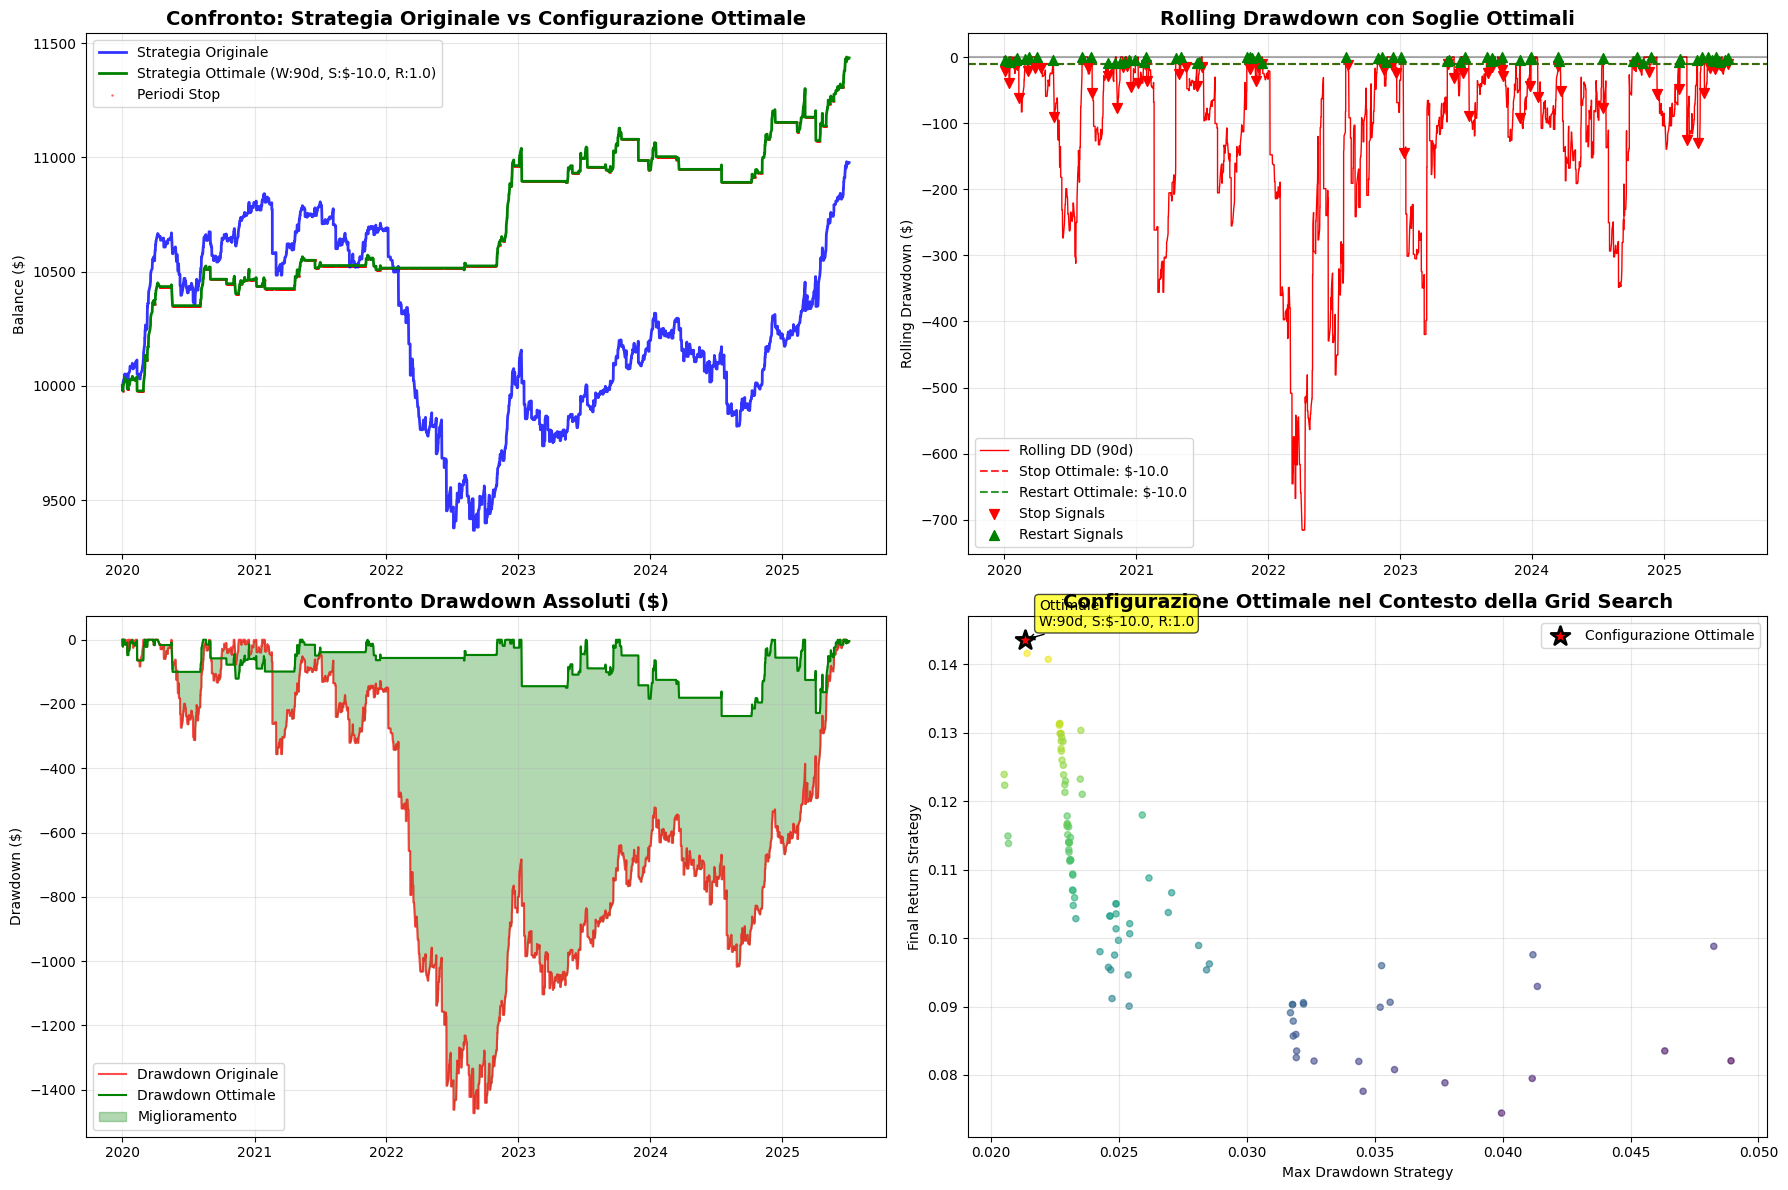


🔍 STATISTICHE DETTAGLIATE CONFIGURAZIONE OTTIMALE:
⏰ OPERAZIONI:
   Numero di Stop:     64
   Numero di Restart:  64
   Tempo in Stop:      71.9% (2579 periodi)

📈 CONFRONTO CON CONFIGURAZIONE ORIGINALE:
   Originale (W:180d, S:$-2, R:0.5):
   → Miglioramento: $-95.50 (-0.87%)
   Ottimale (W:90d, S:$-10.0, R:1.0):
   → Miglioramento: $458.50 (4.18%)
   💡 Differenza: $554.00 (580.1%)

🎯 RACCOMANDAZIONE FINALE:
✅ Usa questi parametri ottimali per la tua strategia:
   ROLLING_WINDOW_DAYS = 90
   STOP_THRESHOLD_USD = -10.0
   RESTART_MULTIPLIER = 1.0


In [44]:
# 📊 VISUALIZZAZIONE DELLA MIGLIORE CONFIGURAZIONE TROVATA

print("🎯 SIMULAZIONE CON I PARAMETRI OTTIMALI TROVATI")
print("="*80)

# Estrai i parametri ottimali
optimal_window = int(best_balanced['window_days'])
optimal_stop = best_balanced['stop_threshold']
optimal_restart = best_balanced['restart_multiplier']

print(f"📋 PARAMETRI OTTIMALI:")
print(f"   Window: {optimal_window} giorni")
print(f"   Stop Threshold: ${optimal_stop}")
print(f"   Restart Multiplier: {optimal_restart}")

# Simula con i parametri ottimali (con output dettagliato)
df_optimal = simulate_stop_strategy(df, 
                                   stop_threshold_usd=optimal_stop,
                                   restart_multiplier=optimal_restart,
                                   window_days=optimal_window)

# Calcola le metriche ottimali
optimal_original_balance = df['BALANCE'].iloc[-1]
optimal_final_balance = df_optimal[0]['adjusted_balance'].iloc[-1]
optimal_improvement = optimal_final_balance - optimal_original_balance

print(f"\n📊 PERFORMANCE CON PARAMETRI OTTIMALI:")
print(f"   Original Balance: ${optimal_original_balance:.2f}")
print(f"   Final Balance:    ${optimal_final_balance:.2f}")
print(f"   Improvement:      ${optimal_improvement:.2f} ({optimal_improvement/optimal_original_balance*100:.2f}%)")

# Visualizzazione completa della configurazione ottimale
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Confronto balance originale vs ottimale
ax1.plot(df_optimal[0]['DATE'], df_optimal[0]['BALANCE'], 
         label='Strategia Originale', linewidth=2, alpha=0.8, color='blue')
ax1.plot(df_optimal[0]['DATE'], df_optimal[0]['adjusted_balance'], 
         label=f'Strategia Ottimale (W:{optimal_window}d, S:${optimal_stop}, R:{optimal_restart})', 
         linewidth=2, color='green')

# Evidenzia periodi di stop
stop_periods = df_optimal[0][df_optimal[0]['active'] == False]
if len(stop_periods) > 0:
    ax1.scatter(stop_periods['DATE'], stop_periods['adjusted_balance'], 
               color='red', s=1, alpha=0.4, label='Periodi Stop')

ax1.set_title('Confronto: Strategia Originale vs Configurazione Ottimale', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Balance ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling drawdown con soglie ottimali
ax2.plot(df_optimal[0]['DATE'], df_optimal[0]['rolling_drawdown_abs'], 
         linewidth=1, color='red', label=f'Rolling DD ({optimal_window}d)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(y=optimal_stop, color='red', linestyle='--', alpha=0.8, 
           label=f'Stop Ottimale: ${optimal_stop}')
ax2.axhline(y=optimal_stop * optimal_restart, color='green', 
           linestyle='--', alpha=0.8, label=f'Restart Ottimale: ${optimal_stop * optimal_restart:.1f}')

# Segnali stop/restart
stop_signals = df_optimal[0][df_optimal[0]['stop_signals'] == 1]
restart_signals = df_optimal[0][df_optimal[0]['restart_signals'] == 1]

if len(stop_signals) > 0:
    ax2.scatter(stop_signals['DATE'], stop_signals['rolling_drawdown_abs'], 
               color='red', s=50, marker='v', label='Stop Signals', zorder=5)
if len(restart_signals) > 0:
    ax2.scatter(restart_signals['DATE'], restart_signals['rolling_drawdown_abs'], 
               color='green', s=50, marker='^', label='Restart Signals', zorder=5)

ax2.set_title('Rolling Drawdown con Soglie Ottimali', fontsize=14, fontweight='bold')
ax2.set_ylabel('Rolling Drawdown ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Confronto drawdown assoluti
def compute_drawdown_abs(series):
    running_max = series.expanding().max()
    return series - running_max

original_dd_abs = compute_drawdown_abs(df_optimal[0]['BALANCE'])
optimal_dd_abs = compute_drawdown_abs(df_optimal[0]['adjusted_balance'])

ax3.plot(df_optimal[0]['DATE'], original_dd_abs, 
         label='Drawdown Originale', color='red', linewidth=1.5, alpha=0.7)
ax3.plot(df_optimal[0]['DATE'], optimal_dd_abs, 
         label='Drawdown Ottimale', color='green', linewidth=1.5)
ax3.fill_between(df_optimal[0]['DATE'], original_dd_abs, optimal_dd_abs, 
                alpha=0.3, color='green', label='Miglioramento')
ax3.set_title('Confronto Drawdown Assoluti ($)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Drawdown ($)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Distribuzione dei risultati della grid search con ottimale evidenziato
ax4.scatter(results_df['max_dd_strategy'], results_df['final_return_strategy'], 
           c=results_df['combined_score'], cmap='viridis', alpha=0.6, s=20)
ax4.scatter(best_balanced['max_dd_strategy'], best_balanced['final_return_strategy'], 
           color='red', s=200, marker='*', label='Configurazione Ottimale', 
           zorder=5, edgecolor='black', linewidth=2)

# Aggiungi annotazione per la configurazione ottimale
ax4.annotate(f'Ottimale\nW:{optimal_window}d, S:${optimal_stop}, R:{optimal_restart}',
            xy=(best_balanced['max_dd_strategy'], best_balanced['final_return_strategy']),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax4.set_title('Configurazione Ottimale nel Contesto della Grid Search', fontsize=14, fontweight='bold')
ax4.set_xlabel('Max Drawdown Strategy')
ax4.set_ylabel('Final Return Strategy')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcola statistiche aggiuntive sulla configurazione ottimale
periods_stopped_optimal = len(df_optimal[0][df_optimal[0]['active'] == False])
time_stopped_pct_optimal = periods_stopped_optimal / len(df_optimal[0]) * 100

print(f"\n🔍 STATISTICHE DETTAGLIATE CONFIGURAZIONE OTTIMALE:")
print("="*80)
print(f"⏰ OPERAZIONI:")
print(f"   Numero di Stop:     {df_optimal[1]}")
print(f"   Numero di Restart:  {df_optimal[2]}")
print(f"   Tempo in Stop:      {time_stopped_pct_optimal:.1f}% ({periods_stopped_optimal} periodi)")

# Confronto con configurazione originale del notebook
print(f"\n📈 CONFRONTO CON CONFIGURAZIONE ORIGINALE:")
print(f"   Originale (W:{ROLLING_WINDOW_DAYS}d, S:${STOP_THRESHOLD_USD}, R:{RESTART_MULTIPLIER}):")
print(f"   → Miglioramento: ${improvement:.2f} ({improvement/original_balance*100:.2f}%)")
print(f"   Ottimale (W:{optimal_window}d, S:${optimal_stop}, R:{optimal_restart}):")
print(f"   → Miglioramento: ${optimal_improvement:.2f} ({optimal_improvement/optimal_original_balance*100:.2f}%)")
print(f"   💡 Differenza: ${optimal_improvement - improvement:.2f} ({((optimal_improvement - improvement)/abs(improvement) if improvement != 0 else 0)*100:.1f}%)")

print(f"\n🎯 RACCOMANDAZIONE FINALE:")
print("="*80)
print(f"✅ Usa questi parametri ottimali per la tua strategia:")
print(f"   ROLLING_WINDOW_DAYS = {optimal_window}")
print(f"   STOP_THRESHOLD_USD = {optimal_stop}")
print(f"   RESTART_MULTIPLIER = {optimal_restart}")
print("="*80)